Este proyecto se originó a partir del trabajo efectuado para la startup 'Market of Waste', donde se necesitaba una amplia base de datos sobre diversos materiales presentes en Chile, detallando sus precios y valorización económica. Dicha base de datos se ha convertido en una herramienta clave para el análisis y comparación con múltiples iniciativas de 'Upcycling'. Para la compilación de estos datos, se utilizó una base de datos específica del proyecto, enriquecida mediante técnicas avanzadas de 'Web Scraping' y el uso de SerpApi. En todo momento, se mantuvo un firme compromiso con el respeto a las políticas de confidencialidad de las empresas y clientes implicados, garantizando así la integridad y privacidad de la información recabada.

//

This project originated from the work carried out for the startup 'Market of Waste', where a comprehensive database of various materials in Chile was required, including their pricing and economic valuation. This database has become a key tool for analysis and comparison with multiple 'Upcycling' initiatives. For the compilation of this data, a project-specific database was used, enhanced through advanced 'Web Scraping' techniques and the use of SerpApi. Throughout the process, a strong commitment was maintained to respect the confidentiality policies of the involved companies and clients, thus ensuring the integrity and privacy of the collected information.

[![Market of Waste: Tus residuos son un tesoro](https://i.ytimg.com/vi/Rccz2DkfWpc/mqdefault.jpg)](https://www.youtube.com/watch?v=Rccz2DkfWpc)



In [ ]:
import datetime
from google.cloud import bigquery
import pandas as pd
import pytz
from google.oauth2 import service_account
import uuid
from serpapi import GoogleSearch
import pyarrow as pa

#Solo una propuesta a adaptar segun las necesidades de busqueda
#Only a proposal to adapt according to the search need
"""
ateriales = [
    "Orgánica",
    "Strech film", 
    "Polietileno de baja transparente",
    "Polietileno de baja para lavado",
    "Techo invernadero (no degradado y sin impurezas)",
    "Botellas Pet blanca",
    "Botellas Pet color",
    "PAPELES Y CARTONES",
    "Papel de oficina (Blanco 2)",
    "Mixto corriente",
    "Duplex",
    "Carton corrugado",
    "Diario",
    "VIDRIO",
    "Vidrio de botellas",
    "Vidrio de frascos",
    "CHATARRA",
    "Fierro chatarra",
    "Lata chatarra",
    "Aluminio de latas bebidas",
    "Aluminio",
    "Cobre",
    "Papeles y Cartones",
    "Plastico",
    "Vidrio",
    "Metales",
    "Textil",
    "CARTON",
    "ALUMINIO",  # Puedes agregar más especificidad como 'latas aplastadas', 'jugo', 'cerveza'
    "METALES",  # Agrega especificidad si es necesario, como 'tarros de conserva', 'aerosol spray', 'chatarra'
    "PAPEL TIPO 1",
    "PAPEL TIPO 2",
    "PAPEL TIPO 3",
    "PLASTICOS PET-1",  # Añade 'botellas plásticas desechables -sin tapa' para especificar
    "PLASTICOS PET-1 COLOR",  # Añade 'botellas plásticas desechables -sin tapa' para especificar
    "PLASTICOS PEAD-2",  # Añade 'shampoo', 'bolsas', 'juguetes' para especificar
    "PLASTICOS PP-5",  # Añade 'tapas de botellas', 'bolsas de alimentos y ropa' para especificar
    "TETRA PAK",
    "VIDRIOS blanco"  # Añade 'botellas' para especificar
]
"""

materiales = ["reciclaje"]  
precios = ["precio"]
search_terms = [f"{material} {precio}" for material in materiales for precio in precios]

search_location = "Chile"
all_results = pd.DataFrame()

for search_term in search_terms:  
    for num in range(40):  
        start = num * 10
        params = {
            "api_key": "xxxxxxxxxxxxxxxxxxxxxxx",
            "device": "desktop",
            "engine": "google",
            "google_domain": "google.cl",
            "q": search_term,
            "hl": "es",
            "gl": "cl",
            "location": search_location,
            "start": start,
        }

        search = GoogleSearch(params)
        results = search.get_dict()

       
        current_page_results = pd.DataFrame(results.get('organic_results', []))
        all_results = pd.concat([all_results, current_page_results], ignore_index=True)

all_results



En este proyecto, utilizamos Google Cloud Platform (GCP) para almacenar los dataframes generados, aprovechando la robustez y capacidad de Google Cloud Storage. Elegimos Google BigQuery como nuestra principal herramienta de análisis debido a su eficiencia en el manejo de grandes volúmenes de datos. Esta integración se realizó sin problemas, facilitada por un convenio entre la startup y Google, asegurando una gestión eficiente y segura de los datos en la nube.

//

In this project, we utilized Google Cloud Platform (GCP) for storing the generated dataframes, harnessing the robustness and capacity of Google Cloud Storage. We chose Google BigQuery as our main analysis tool, given its efficiency in handling large data volumes. This integration was seamlessly facilitated by an existing agreement between the startup and Google, ensuring efficient and secure data management in the cloud.

In [ ]:
# Ruta al archivo JSON credencial//Path to credentials JSON file
key_path = "your_Path/real/file.json"

# ID proyecto Google Cloud// Google Cloud project ID/
project_id = "MOW"

# ID DadaFrame & nombre tabla en BigQuery//# DadaFrame ID & table name in BigQuery
dataset_id = "xxxxxxxxxxxxxxxxxxxxxxxxxxx"
table_name = "xxxxxxxxxxxxxxxxx"

# ID completo de la tabla//Full ID of the table
table_id = f"{project_id}.{dataset_id}.{table_name}"

# Cargar credencial(JSON file)//Load credential(JSON file)//
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
# Creacion cliente de BigQuery//# BigQuery client creation
client = bigquery.Client(credentials=credentials, project=project_id)

# Insertar resultados en tabla de BigQuery//# Insert results into BigQuery table
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

job = client.load_table_from_dataframe(all_results, table_id, job_config=job_config)
job.result() 

print(f"Data loaded into table {table_id}")

Upon successful storage of the data, we initiated a meticulous filtration process on the generated dataframe. This was done to align it with the specific requirements and anticipated applications of the project. The filtration involved an in-depth extraction of targeted information from a range of websites, ensuring the data was precisely curated to meet the project's objectives.

In [ ]:
urls = ["https://reciclaje123.cl",
        #"https://xxxxxxxxxxxxxx.cl",
        #................
        ]

datos = []

for url in urls:
    try:
        respuesta = requests.get(url)
        contenido_web = respuesta.content
        soup = BeautifulSoup(contenido_web, 'html.parser')
        tabla = soup.find('table', {'class': 'tableizer-table'})

        if tabla:
            for fila in tabla.find_all('tr')[1:]:
                columnas = fila.find_all('td')
                if len(columnas) == 2:
                    material = columnas[0].text.strip()
                    precio = columnas[1].text.strip()
                    datos.append((url, material, precio))
    except Exception as e:
        print(f"Error al procesar {url}: {e}")

df = pd.DataFrame(datos, columns=['URL', 'Material', 'Precio'])
df

In [5]:
import pandas as pd

df = pd.read_csv("final_report.csv")

df

,Término de búsqueda,Tipo de concordan cia,Agregadas\n/excluidas,Campaña,Grupo de anuncios,Clics,Impr.,CTR,Código de moneda,Prom. CPC,Conversion es
0,reusar ejemplos,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,2,0.000,CLP,--,0
1,qué podemos reciclar para cuidar el medio ambi...,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0
2,venta de plástico reciclado,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,5,0.000,CLP,--,0
3,cosas para reciclar en casa,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0
4,como se recicla el pvc,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0
...,...,...,...,...,...,...,...,...,...,...,...
5056,imagenes de reciclar botellas,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0
5057,happy plugs chile,Concordan cia de frase (variante cercana),Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0
5058,empresas de reciclaje chile,Concordan cia amplia,Ninguna,Search-1,Grupo de anuncios 1,1,8,0.125,CLP,104,0
5059,www denda,Concordan cia exacta (variante cercana),Ninguna,Search-1,Grupo de anuncios 1,0,1,0.000,CLP,--,0


In [6]:
df.columns

Index(['Término de búsqueda', 'Tipo de concordan cia', 'Agregadas\n/excluidas',
       'Campaña', 'Grupo de anuncios', 'Clics', 'Impr.', 'CTR',
       'Código de moneda', 'Prom. CPC', 'Conversion es'],
      dtype='object')

In [7]:
df.dtypes

Término de búsqueda       object
Tipo de concordan cia     object
Agregadas\n/excluidas     object
Campaña                   object
Grupo de anuncios         object
Clics                      int64
Impr.                      int64
CTR                      float64
Código de moneda          object
Prom. CPC                 object
Conversion es              int64
dtype: object

In [9]:
df.columns = df.columns.str.replace('\n', ' ').str.strip()
df.columns = [
    'Termino_de_busqueda', 'Tipo_de_concordancia', 'Agregadas_excluidas',
    'Campana', 'Grupo_de_anuncios', 'Clics', 'Impresiones', 'CTR',
    'Codigo_de_moneda', 'Prom_CPC', 'Conversiones'
]


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace('.', '')
df = df.rename(columns={
    'Término de búsqueda': 'Termino_de_busqueda',
    'Tipo de concordan cia': 'Tipo_de_concordancia',
    'Agregadas excluidas': 'Agregadas_excluidas',
    'Grupo de anuncios': 'Grupo_de_anuncios',
    'Impr': 'Impresiones',
    'Prom CPC': 'Prom_CPC',
    'Conversion es': 'Conversiones'
})

df['Prom_CPC'] = pd.to_numeric(df['Prom_CPC'].astype(str).str.replace('--', '0'), errors='coerce')

/var/folders/fp/bhc0ytp57533fd1q0g_9swtr0000gn/T/ipykernel_12199/4213647948.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace('.', '')


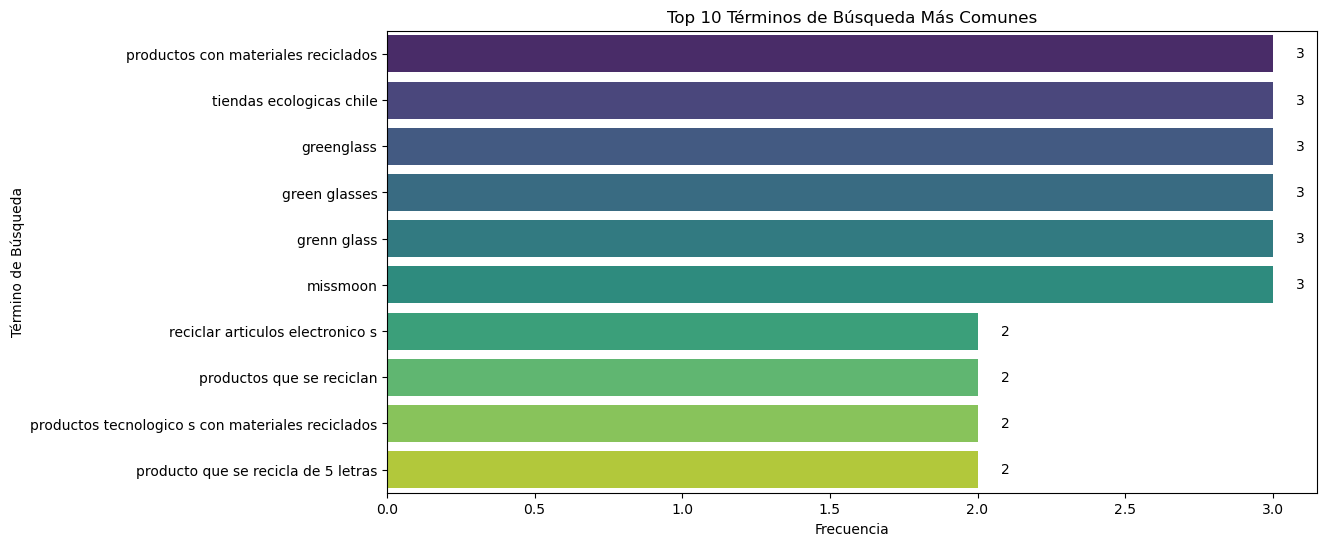

In [13]:
top_terminos = df['Termino_de_busqueda'].value_counts().head(10).reset_index()
top_terminos.columns = ['Termino_de_busqueda', 'Frecuencia']

plt.figure(figsize=(12, 6))
sns_bar = sns.barplot(x='Frecuencia', y='Termino_de_busqueda', data=top_terminos, palette='viridis')

plt.xlabel('Frecuencia')
plt.ylabel('Término de Búsqueda')
plt.title('Top 10 Términos de Búsqueda Más Comunes')

for p in sns_bar.patches:
    sns_bar.annotate(format(p.get_width(), '.0f'), 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', 
                     va = 'center', 
                     xytext = (20, 0), 
                     textcoords = 'offset points')
plt.show()


In [16]:
# Análisis de Concordancia y su Impacto
rendimiento_concordancia = df.groupby('Tipo_de_concordancia')['Clics', 'Impresiones', 'CTR', 'Conversiones'].mean()
print(rendimiento_concordancia)

                                              Clics  Impresiones       CTR  \
Tipo_de_concordancia                                                         
Concordan cia amplia                       0.123226     3.616129  0.034931   
Concordan cia de frase                     0.176707     3.618474  0.041726   
Concordan cia de frase (variante cercana)  0.230769     3.472527  0.054009   
Concordan cia exacta                       3.785714   137.000000  0.036607   
Concordan cia exacta (variante cercana)    0.280702     3.666667  0.102277   

                                           Conversiones  
Tipo_de_concordancia                                     
Concordan cia amplia                           0.007097  
Concordan cia de frase                         0.024096  
Concordan cia de frase (variante cercana)      0.021978  
Concordan cia exacta                           0.142857  
Concordan cia exacta (variante cercana)        0.035088  


/var/folders/fp/bhc0ytp57533fd1q0g_9swtr0000gn/T/ipykernel_12199/496220309.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rendimiento_concordancia = df.groupby('Tipo_de_concordancia')['Clics', 'Impresiones', 'CTR', 'Conversiones'].mean()


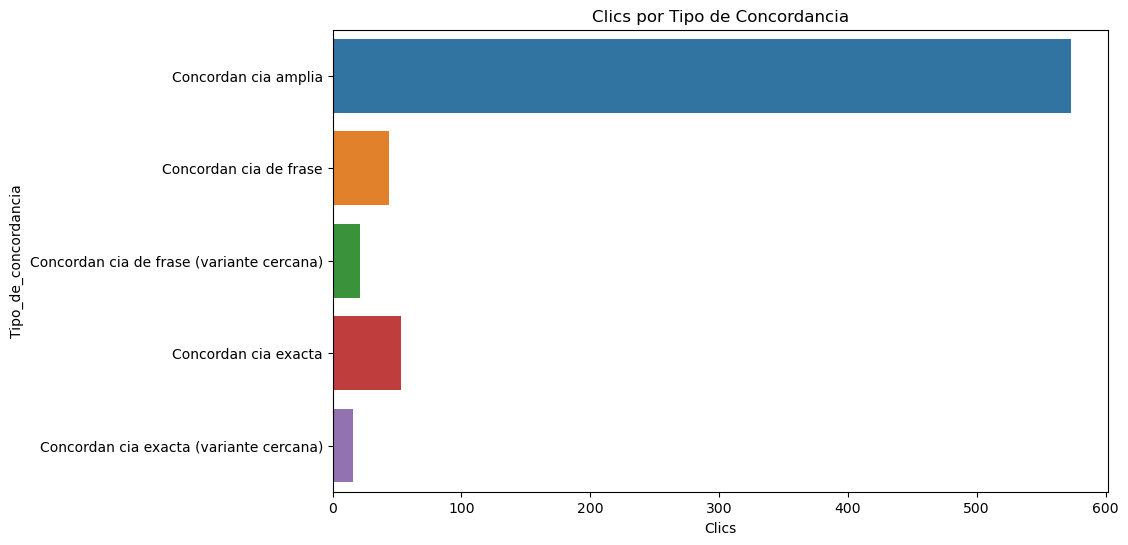

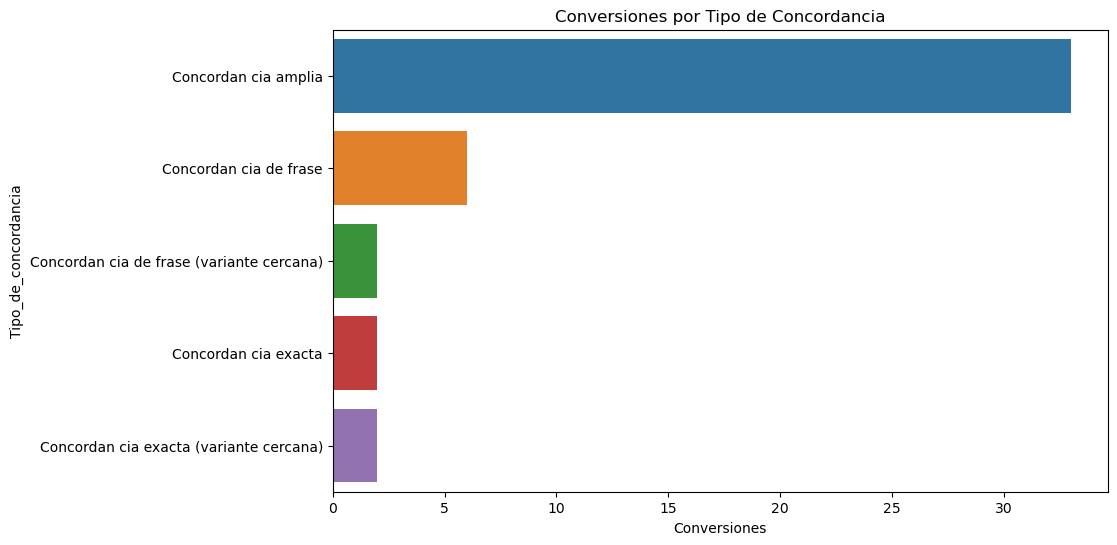

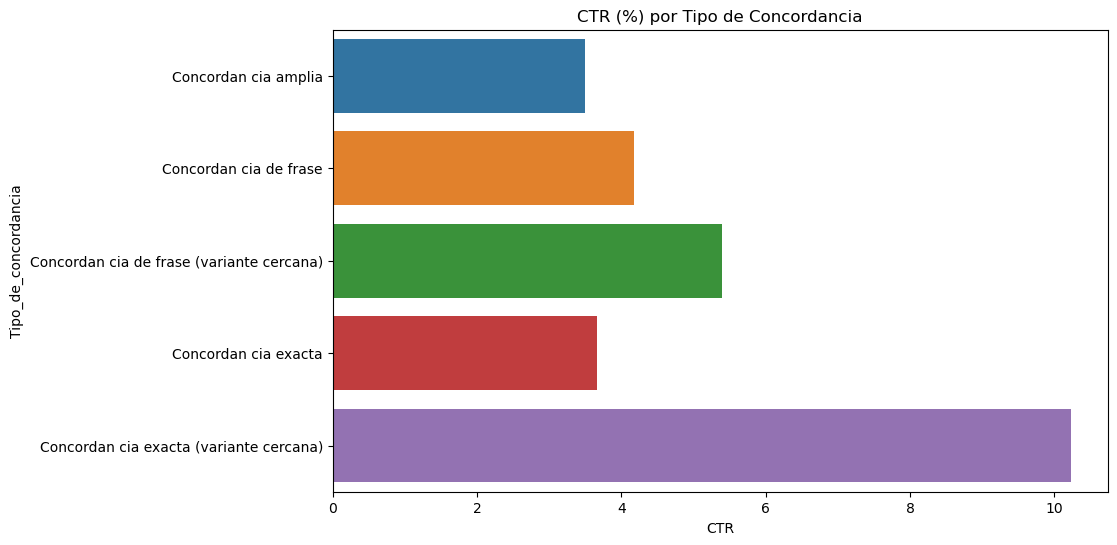

In [14]:

grouped_by_concordance = df.groupby('Tipo_de_concordancia').agg({'Clics': 'sum', 'Conversiones': 'sum', 'CTR': 'mean'}).reset_index()

grouped_by_concordance['CTR'] = grouped_by_concordance['CTR'] * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Clics', y='Tipo_de_concordancia', data=grouped_by_concordance)
plt.title('Clics por Tipo de Concordancia')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Conversiones', y='Tipo_de_concordancia', data=grouped_by_concordance)
plt.title('Conversiones por Tipo de Concordancia')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='CTR', y='Tipo_de_concordancia', data=grouped_by_concordance)
plt.title('CTR (%) por Tipo de Concordancia')
plt.show()


/var/folders/fp/bhc0ytp57533fd1q0g_9swtr0000gn/T/ipykernel_12199/2609679704.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rendimiento_grupo = df.groupby('Grupo_de_anuncios')['Clics', 'Impresiones', 'CTR', 'Conversiones'].sum()


                     Clics  Impresiones       CTR  Conversiones
Grupo_de_anuncios                                              
Grupo de anuncios 1    707        20159  184.0752            45


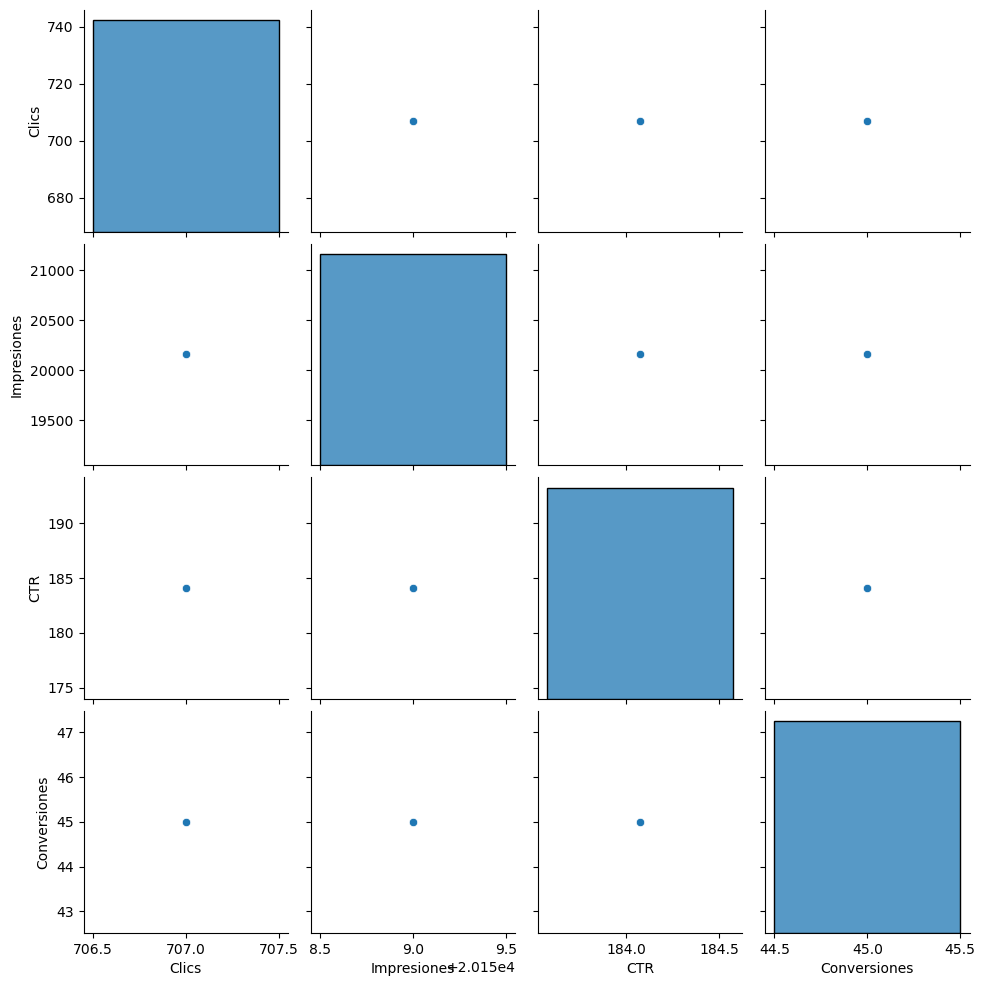

In [15]:
#Evaluación del Rendimiento por Grupo de Anuncios

rendimiento_grupo = df.groupby('Grupo_de_anuncios')['Clics', 'Impresiones', 'CTR', 'Conversiones'].sum()
print(rendimiento_grupo)

sns.pairplot(rendimiento_grupo)
plt.show()